# Granule subtyping for paired WT and AD benchmark samples

This notebook completes granule subtyping and annotation for the **main result** (optimal mcDETECT) and for **benchmark settings** (benchmark_rho, benchmark_filtering, benchmark_sphere, etc.). The main result uses pre-built data at `output/MERSCOPE_WT_AD_comparison/granule_adata_tsne.h5ad` (already concatenated and normalized); for other settings we load from `MERSCOPE_WT_1_representative_data` and `MERSCOPE_AD_1_representative_data`. For each setting we:
1. Load data (main result: load h5ad; benchmark: concatenate WT+AD and normalize).
2. Subtype granules (manual: k-means + heatmap → annotation; optional automatic tuning).
3. Export labels and density (main result and benchmark: per-setting files). For main result only: save tSNE and heatmap as jpeg to `output/MERSCOPE_WT_AD_comparison/`.

In [1]:
import anndata
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scanpy as sc
from sklearn.cluster import MiniBatchKMeans

from mcDETECT.utils import *
from mcDETECT.model import mcDETECT
from mcDETECT.downstream import spot_granule, classify_granules

import warnings
warnings.filterwarnings("ignore")
sc.settings.verbosity = 0

/Users/chenyang/miniconda3/envs/mcDETECT-env/lib/python3.10/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound
/Users/chenyang/miniconda3/envs/mcDETECT-env/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/Users/chenyang/miniconda3/envs/mcDETECT-env/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/Users/chenyang/miniconda3/envs/mcDETECT-env/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read

## 1. Paths and parameters

In [2]:
# Benchmark root: output/benchmark/
BENCHMARK_ROOT = "../../output/benchmark/"

# Data paths for WT and AD (for transcripts, genes, spots when building profiles or computing density)
DATA_PATH_WT = "../../data/MERSCOPE_WT_1/"
DATA_PATH_AD = "../../data/MERSCOPE_AD_1/"

# Folder names for representative data under each benchmark_xxx
WT_REPR_DIR = "MERSCOPE_WT_1_representative_data"
AD_REPR_DIR = "MERSCOPE_AD_1_representative_data"

# Output subfolder under each benchmark_xxx for labels and density
COMPARISON_DIR = "WT_AD_comparison"

# Main result: pre-built concatenated + normalized adata with tSNE
MAIN_RESULT_DIR = "../../output/MERSCOPE_WT_AD_comparison"
MAIN_RESULT_PATH = os.path.join(MAIN_RESULT_DIR, "granule_adata_tsne.h5ad")

In [3]:
# Granule markers
marker_genes = {"pre-syn": ["Bsn", "Gap43", "Nrxn1", "Slc17a6", "Slc17a7", "Slc32a1", "Snap25", "Stx1a", "Syn1", "Syp", "Syt1", "Vamp2", "Cplx2"],
                "post-syn": ["Camk2a", "Dlg3", "Dlg4", "Gphn", "Gria1", "Gria2", "Homer1", "Homer2", "Nlgn1", "Nlgn2", "Nlgn3", "Shank1", "Shank3"],
                "axons": ["Ank3", "Nav1", "Sptnb4", "Nfasc", "Mapt", "Tubb3"],
                "dendrites": ["Actb", "Cyfip2", "Ddn", "Dlg4", "Map1a", "Map2"]}
ref_genes = ["Bsn", "Gap43", "Nrxn1", "Slc17a6", "Slc17a7", "Slc32a1", "Stx1a", "Syn1", "Syp", "Syt1", "Vamp2", "Cplx2", "Camk2a", "Dlg3", "Dlg4", "Gphn", "Gria1", "Gria2", "Homer1", "Homer2", "Nlgn1", "Nlgn2", "Nlgn3", "Shank1", "Shank3", "Cyfip2", "Ddn", "Map1a", "Map2", "Ank3", "Nav1", "Nfasc", "Mapt", "Tubb3"]
gnl_genes = ["Camk2a", "Cplx2", "Slc17a7", "Ddn", "Syp", "Map1a", "Shank1", "Syn1", "Gria1", "Gria2", "Cyfip2", "Vamp2", "Bsn", "Slc32a1", "Nfasc", "Syt1", "Tubb3", "Nav1", "Shank3", "Mapt"]

## 2. Explicit list of benchmark settings

Under each benchmark (benchmark_rho, benchmark_filtering, benchmark_sphere), WT and AD outputs are stored in
`MERSCOPE_WT_1_representative_data/` and `MERSCOPE_AD_1_representative_data/` with **the same filename** for a given parameter setting.
Format is inferred from extension: `.parquet` → granules, build profile via mc.profile(); `.h5ad` → expression profile, load directly.

In [4]:
# Main result first, then benchmark settings.
# (benchmark_name, filename) — for benchmark: same filename in WT and AD folders. For main_result: filename used as setting_key.
BENCHMARK_SETTINGS = [
    
    # main_result: pre-built concatenated + normalized; not from benchmark dirs
    ("main_result", "granule_adata_tsne.h5ad"), 
    
    # benchmark_filtering: inSomaThr and ncThr (parquet)
    ("benchmark_filtering", "granules_inSomaThr1.0_ncThr1.0.parquet"),
    ("benchmark_filtering", "granules_inSomaThr0.1_ncThr1.0.parquet"),
    ("benchmark_filtering", "granules_inSomaThr1.0_ncThr0.1.parquet"),
    ("benchmark_filtering", "granules_inSomaThr0.1_ncThr0.1.parquet"),
    
    # benchmark_sphere: radius setting (h5ad = expression profile)
    ("benchmark_sphere", "granules_expression_default.h5ad"),
    ("benchmark_sphere", "granules_expression_fixed.h5ad"),
    ("benchmark_sphere", "granules_expression_expand.h5ad"),
    ("benchmark_sphere", "granules_expression_shrink.h5ad"),
    
    # # benchmark_rho: representative rho values (parquet)
    # ("benchmark_rho", "granules_rho_0.0.parquet"),
    # ("benchmark_rho", "granules_rho_0.2.parquet"),
    # ("benchmark_rho", "granules_rho_0.4.parquet"),
    # ("benchmark_rho", "granules_rho_0.6.parquet"),
    
]
print(f"Total settings: {len(BENCHMARK_SETTINGS)}")

for bench, fname in BENCHMARK_SETTINGS:
    fmt = "parquet (build profile)" if fname.endswith(".parquet") else "h5ad (load)"
    print(f"  {bench} / {fname}  [{fmt}]")

Total settings: 9
  main_result / granule_adata_tsne.h5ad  [h5ad (load)]
  benchmark_filtering / granules_inSomaThr1.0_ncThr1.0.parquet  [parquet (build profile)]
  benchmark_filtering / granules_inSomaThr0.1_ncThr1.0.parquet  [parquet (build profile)]
  benchmark_filtering / granules_inSomaThr1.0_ncThr0.1.parquet  [parquet (build profile)]
  benchmark_filtering / granules_inSomaThr0.1_ncThr0.1.parquet  [parquet (build profile)]
  benchmark_sphere / granules_expression_default.h5ad  [h5ad (load)]
  benchmark_sphere / granules_expression_fixed.h5ad  [h5ad (load)]
  benchmark_sphere / granules_expression_expand.h5ad  [h5ad (load)]
  benchmark_sphere / granules_expression_shrink.h5ad  [h5ad (load)]


## 3. Load one file per sample and concatenate

In [5]:
def load_genes_and_transcripts(data_path):
    genes_df = pd.read_csv(os.path.join(data_path, "processed_data/genes.csv"))
    genes = list(genes_df.iloc[:, 0])
    transcripts = pd.read_parquet(os.path.join(data_path, "processed_data/transcripts.parquet"))
    if "target" not in transcripts.columns and "gene" in transcripts.columns:
        transcripts = transcripts.rename(columns={"gene": "target"})
    return genes, transcripts

def build_mc(transcripts, gnl_genes, nc_genes, **kwargs):
    """Build mcDETECT instance for profile()."""
    return mcDETECT(type="discrete", transcripts=transcripts, gnl_genes=gnl_genes, nc_genes=nc_genes or [],
        eps=1.5, minspl=3, grid_len=1, cutoff_prob=0.95, alpha=10, low_bound=3, size_thr=4.0,
        in_soma_thr=0.1, l=1, rho=0.2, s=1, nc_top=20, nc_thr=0.1, **kwargs)

def load_one_sample(path, sample_label, genes, mc, is_parquet):
    """Load a single WT or AD sample from one file. Returns adata with obs['sample'] = sample_label."""
    if is_parquet:
        granules = pd.read_parquet(path)
        adata = mc.profile(granules, genes=genes)
    else:
        adata = sc.read_h5ad(path)
    adata.obs["sample"] = sample_label
    return adata

def concatenate_wt_ad_for_setting(benchmark_name, filename, genes_wt, genes_ad, transcripts_wt, transcripts_ad, nc_wt, nc_ad, ref_genes_common):
    """
    Load the **same filename** from WT and AD representative dirs for this benchmark, then concatenate.
    - .parquet → build profile with mc.profile(granules, genes) for WT and AD separately.
    - .h5ad → load directly.
    Returns combined adata with obs['sample'] in ('WT', 'AD'), var restricted to ref_genes_common.
    """
    wt_dir = os.path.join(BENCHMARK_ROOT, benchmark_name, WT_REPR_DIR)
    ad_dir = os.path.join(BENCHMARK_ROOT, benchmark_name, AD_REPR_DIR)
    path_wt = os.path.join(wt_dir, filename)
    path_ad = os.path.join(ad_dir, filename)
    if not os.path.isfile(path_wt):
        raise FileNotFoundError(f"WT file not found: {path_wt}")
    if not os.path.isfile(path_ad):
        raise FileNotFoundError(f"AD file not found: {path_ad}")

    is_parquet = filename.endswith(".parquet")
    if is_parquet:
        mc_wt = build_mc(transcripts_wt, gnl_genes=gnl_genes, nc_genes=nc_wt)
        mc_ad = build_mc(transcripts_ad, gnl_genes=gnl_genes, nc_genes=nc_ad)
        adata_wt = load_one_sample(path_wt, "WT", genes_wt, mc_wt, True)
        adata_ad = load_one_sample(path_ad, "AD", genes_ad, mc_ad, True)
    else:
        adata_wt = load_one_sample(path_wt, "WT", None, None, None, False)
        adata_ad = load_one_sample(path_ad, "AD", None, None, None, False)

    common = [g for g in ref_genes_common if g in adata_wt.var_names and g in adata_ad.var_names]
    adata_wt = adata_wt[:, common].copy()
    adata_ad = adata_ad[:, common].copy()
    adata = anndata.concat([adata_wt, adata_ad], join="outer", label="sample", keys=["WT", "AD"])
    adata.obs["sample"] = adata.obs["sample"].astype(str)
    return adata

In [6]:
# Load genes and transcripts once (for profile() when data are parquet)
genes_wt, transcripts_wt = load_genes_and_transcripts(DATA_PATH_WT)
genes_ad, transcripts_ad = load_genes_and_transcripts(DATA_PATH_AD)
nc_wt = list(pd.read_csv(os.path.join(DATA_PATH_WT, "processed_data/negative_controls.csv"))["Gene"])
nc_ad = list(pd.read_csv(os.path.join(DATA_PATH_AD, "processed_data/negative_controls.csv"))["Gene"])
ref_genes_common = [g for g in ref_genes if g in genes_wt and g in genes_ad]
print(f"Marker genes present in both WT and AD: {len(ref_genes_common)}")

Marker genes present in both WT and AD: 34


## 4. Per-setting pipeline: subtyping and export

In [7]:
# K-means and manual subtyping parameters (reproducibility: all driven by SEED)
N_CLUSTERS = 15
KMEANS_BATCH_SIZE = 5000
KMEANS_N_INIT = 20

# Main result only: additional k values for cluster-count sensitivity (only subtype labels parquet saved; no tSNE/heatmap/density)
MAIN_RESULT_EXTRA_K = [20, 25, 30]

# Brain areas for density
AREA_LIST = ["Isocortex", "OLF", "HPF-CA", "HPF-DG", "HPF-SR", "CTXsp", "TH", "MB", "FT"]

# Convention: granule_subtype_manual = finer labels (e.g. 'pre & post'); use only for defining synaptic granules. Density and automatic-annotation guidance use granule_subtype_manual_simple ('mixed' for mixed types).
# Synaptic subtypes (from granule_subtype_manual) for correlation with ground truth
SYNAPTIC_SUBTYPES = ["pre-syn", "post-syn", "pre & post"]
GROUND_TRUTH_DENSITIES = [1.71603565, 1.964351308, 2.052720791, 1.139278326, 99, 1.678527951, 1.082904337, 0.444031185, 0.0199885]  # 99 = placeholder for HPF-SR

### 4.1 Manual subtyping: k-means (fixed seed) + heatmap, annotation left blank

In [8]:
def run_manual_subtyping(granule_adata, n_clusters, seed, batch_size=5000, n_init=20, obs_key="granule_subtype_kmeans"):
    """K-means on full marker matrix → obs[obs_key]; all randomness controlled by seed."""
    data = granule_adata.X.copy()
    if hasattr(data, "toarray"):
        data = data.toarray()
    np.random.seed(seed)
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size, random_state=seed, n_init=n_init)
    kmeans.fit(data)
    granule_adata.obs[obs_key] = kmeans.labels_.astype(str)
    desired_order = [str(i) for i in range(n_clusters)]
    granule_adata.obs[obs_key] = pd.Categorical(granule_adata.obs[obs_key], categories=desired_order, ordered=True)
    return granule_adata

def apply_manual_annotation(granule_adata, mapping, cluster_column="granule_subtype_kmeans"):
    """Map cluster labels to subtype from mapping dict; add obs['granule_subtype_manual'] and obs['granule_subtype_manual_simple']."""
    k2sub = {}
    for subtype, clusters in mapping.items():
        for c in clusters:
            k2sub[c] = subtype
    granule_adata.obs["granule_subtype_manual"] = granule_adata.obs[cluster_column].astype(str).map(k2sub)
    granule_adata.obs["granule_subtype_manual_simple"] = granule_adata.obs["granule_subtype_manual"].apply(
        lambda s: "mixed" if pd.notna(s) and " & " in str(s) else str(s)
    )
    return granule_adata

def compute_manual_dist(granule_adata, subtype_column="granule_subtype_manual_simple"):
    """Build manual_dist from granule_subtype_manual_simple (for run_automatic_tuning_grid)"""
    manual_props = granule_adata.obs[subtype_column].value_counts(normalize=True)
    manual_dist = {"pre-syn": 0.0, "post-syn": 0.0, "dendrites": 0.0, "axons": 0.0, "mixed": 0.0, "others": 0.0}
    for k, v in manual_props.items():
        if k in manual_dist:
            manual_dist[k] = float(v)
        else:
            manual_dist["others"] = manual_dist.get("others", 0) + float(v)
    return manual_dist

### 4.2 Automatic subtyping: GranuleSubtyper and hyperparameter tuning steps

Steps for tuning automatic subtyping (after you have manual annotation):
1. Define manual distribution (proportions) from your manual annotation, e.g.:
   manual_dist = {'pre-syn': 0.16, 'post-syn': 0.31, 'dendrites': 0.17, 'axons': 0.0, 'mixed': 0.34, 'others': 0.02}
2. Grid search: for (enrichment_threshold, min_zscore_threshold) run classify_granules with cluster_column='granule_subtype_kmeans'
   (or cluster_column=None for granule-level). Get proportion per subtype for each (enrich_thr, zscore_thr).
3. Compute least_square_error = sum over subtypes of (auto_proportion - manual_proportion)^2.
4. Pick (enrich_thr, zscore_thr) with smallest LSE; use that for final automatic labels.

See cells below for the actual grid and LSE computation.

In [9]:
def run_automatic_tuning_grid(granule_adata, marker_genes, manual_dist, cluster_column="granule_subtype_kmeans"):
    """
    Grid over enrichment_threshold and min_zscore_threshold; compute LSE vs manual_dist.
    manual_dist: dict e.g. {'pre-syn': 0.16, 'post-syn': 0.31, 'dendrites': 0.17, 'axons': 0.0, 'mixed': 0.34, 'others': 0.02}
    Returns (results_df, best_enrich_thr, best_zscore_thr).
    """
    enrich_thresholds = [0.2, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.6]
    zscore_thresholds = [-1, -0.5, 0.0, 0.5, 1.0, 1.5, 2]
    dist_cols = ["pre-syn", "post-syn", "dendrites", "axons", "mixed", "others"]
    manual_series = pd.Series(manual_dist).reindex(dist_cols).fillna(0)

    results = []
    for enrich_thr in enrich_thresholds:
        for zscore_thr in zscore_thresholds:
            subtypes, subtypes_simple = classify_granules(
                granule_adata,
                cluster_column=cluster_column,
                enrichment_threshold=enrich_thr,
                min_zscore_threshold=zscore_thr,
                custom_markers=marker_genes,
            )
            counts = subtypes_simple.value_counts(normalize=True)
            row = {
                "enrich_thr": enrich_thr,
                "zscore_thr": zscore_thr,
                **{c: counts.get(c, 0) for c in dist_cols},
            }
            results.append(row)
    results_df = pd.DataFrame(results)
    results_df["least_square_error"] = (
        (results_df[dist_cols].sub(manual_series, axis=1)) ** 2
    ).sum(axis=1)
    best = results_df.sort_values("least_square_error", ascending=True).iloc[0]
    return results_df, best["enrich_thr"], best["zscore_thr"]

def run_automatic_subtyping(granule_adata, marker_genes, enrichment_threshold=0.35, min_zscore_threshold=0.0, cluster_column="granule_subtype_kmeans"):
    """Assign obs['granule_subtype_automated'] and 'granule_subtype_automated_simple' (mixed vs pure)."""
    subtypes, subtypes_simple = classify_granules(
        granule_adata,
        cluster_column=cluster_column,
        enrichment_threshold=enrichment_threshold,
        min_zscore_threshold=min_zscore_threshold,
        custom_markers=marker_genes,
    )
    granule_adata.obs["granule_subtype_automated"] = subtypes.values
    granule_adata.obs["granule_subtype_automated_simple"] = subtypes_simple.values
    return granule_adata

### 4.3 Export labels (parquet) and subtype density (CSV)

In [10]:
def compute_subtype_density_per_region(granule_obs, spots, area_col="brain_area", subtype_col="granule_subtype_manual_simple",
                                        sample_col="sample", coord_keys=("global_x", "global_y"), grid_len=50):
    """
    Spot-level density per subtype: for each (sample, brain_area, subtype), density = sum(granule count in that area) / n_spots in that area.
    granule_obs must have coords (global_x, global_y or sphere_x, sphere_y), sample_col, and subtype_col.
    spots is AnnData with spots.obs containing area_col and coord_keys. Call with one sample's granule_obs and that sample's spots
    (e.g. WT granules + WT spots, AD granules + AD spots) so coordinates are not mixed across samples.
    """
    if area_col not in spots.obs.columns or coord_keys[0] not in spots.obs.columns or coord_keys[1] not in spots.obs.columns:
        return pd.DataFrame()
    half = grid_len / 2
    rows = []
    for sample in granule_obs[sample_col].dropna().unique():
        go = granule_obs[granule_obs[sample_col] == sample].copy()
        xcol = "global_x" if "global_x" in go.columns else "sphere_x"
        ycol = "global_y" if "global_y" in go.columns else "sphere_y"
        if xcol not in go.columns or ycol not in go.columns:
            continue
        for area in spots.obs[area_col].dropna().unique():
            sp = spots.obs.loc[spots.obs[area_col] == area]
            n_spots = len(sp)
            if n_spots == 0:
                continue
            for subtype in go[subtype_col].dropna().unique():
                gs = go.loc[go[subtype_col] == subtype]
                total = 0
                for _, srow in sp.iterrows():
                    x, y = srow[coord_keys[0]], srow[coord_keys[1]]
                    in_spot = (gs[xcol].values >= x - half) & (gs[xcol].values < x + half) & (gs[ycol].values >= y - half) & (gs[ycol].values < y + half)
                    total += in_spot.sum()
                density = total / n_spots
                rows.append({"sample": sample, "brain_area": area, "subtype": subtype, "density": density, "n_spots": n_spots})
    return pd.DataFrame(rows)

def export_setting_results(benchmark_name, setting_key, benchmark_root, comparison_dir, granule_adata, subtype_col="granule_subtype_manual_simple", density_df=None, out_dir=None):
    """
    Export to benchmark_xxx/WT_AD_comparison/ (or out_dir if provided) with setting-specific filenames:
    - granule_subtype_labels_{setting_key}.parquet
    - subtype_density_per_region_{setting_key}.csv
    """
    out_dir = out_dir if out_dir is not None else os.path.join(benchmark_root, benchmark_name, comparison_dir)
    os.makedirs(out_dir, exist_ok=True)
    keep_cols = [c for c in ["granule_id", "sample", subtype_col, "global_x", "global_y", "granule_subtype_kmeans", "granule_subtype_manual"] if c in granule_adata.obs.columns]
    labels_df = granule_adata.obs[keep_cols].copy()
    labels_df.to_parquet(os.path.join(out_dir, f"granule_subtype_labels_{setting_key}.parquet"), index=False)
    if density_df is not None and len(density_df) > 0:
        density_df.to_csv(os.path.join(out_dir, f"subtype_density_per_region_{setting_key}.csv"), index=False)
    print(f"Exported {out_dir}")

def export_labels_only(granule_adata, out_dir, setting_key, label_col, extra_cols=None):
    """Export only subtype labels parquet (e.g. for main result extra k); label_col = obs column with cluster ids."""
    os.makedirs(out_dir, exist_ok=True)
    base = ["granule_id", "sample", label_col, "global_x", "global_y"]
    keep = [c for c in (base + (extra_cols or [])) if c in granule_adata.obs.columns]
    granule_adata.obs[keep].copy().to_parquet(os.path.join(out_dir, f"granule_subtype_labels_{setting_key}.parquet"), index=False)
    print(f"Exported labels {setting_key} -> {out_dir}")

## 5. Run full pipeline for one setting

In [11]:
# Run for the first available setting (or pick another index from BENCHMARK_SETTINGS)
benchmark_name, filename = BENCHMARK_SETTINGS[0]
setting_key = os.path.splitext(filename)[0]  # e.g. granules_rho_0.0 or granule_adata_tsne
is_main_result = (benchmark_name == "main_result")
print(f"Processing: {benchmark_name} / {filename}  (setting_key={setting_key}, is_main_result={is_main_result})")

Processing: main_result / granule_adata_tsne.h5ad  (setting_key=granule_adata_tsne, is_main_result=True)


In [12]:
# Load data: main result = pre-built h5ad (already normalized); else concatenate WT+AD and normalize
if is_main_result:
    adata_combined = sc.read_h5ad(MAIN_RESULT_PATH)
    adata_combined.obs.rename(columns={"batch": "sample"}, inplace=True)
    adata_combined.obs["sample_simple"] = adata_combined.obs["sample"].replace({"MERSCOPE_WT_1": "WT", "MERSCOPE_AD_1": "AD"})
    print(adata_combined.shape)
    print(adata_combined.obs["sample"].value_counts())
else:
    adata_combined = concatenate_wt_ad_for_setting(benchmark_name, filename, genes_wt, genes_ad, transcripts_wt, transcripts_ad, nc_wt, nc_ad, ref_genes_common)
    sc.pp.normalize_total(adata_combined, target_sum=1e4)
    sc.pp.log1p(adata_combined)
    print(adata_combined.shape)
    print(adata_combined.obs["sample"].value_counts())

(1080146, 290)
sample
MERSCOPE_WT_1    681337
MERSCOPE_AD_1    398809
Name: count, dtype: int64


In [13]:
# Manual subtyping: k-means with fixed seed (default: 34 genes → granule_subtype_kmeans)
SEED = 42
np.random.seed(SEED)

run_manual_subtyping(adata_combined, n_clusters=N_CLUSTERS, seed=SEED, batch_size=KMEANS_BATCH_SIZE, n_init=KMEANS_N_INIT)

AnnData object with n_obs × n_vars = 1080146 × 290
    obs: 'global_x', 'global_y', 'global_z', 'layer_z', 'sphere_r', 'size', 'comp', 'in_soma_ratio', 'gene', 'nc_ratio', 'brain_area', 'global_y_new', 'global_x_new', 'granule_id', 'global_x_adjusted', 'global_y_adjusted', 'sample', 'sample_simple', 'granule_subtype_kmeans'
    var: 'genes'
    uns: 'log1p', 'pca', 'tsne'
    obsm: 'X_pca', 'X_tsne'
    varm: 'PCs'
    layers: 'counts'

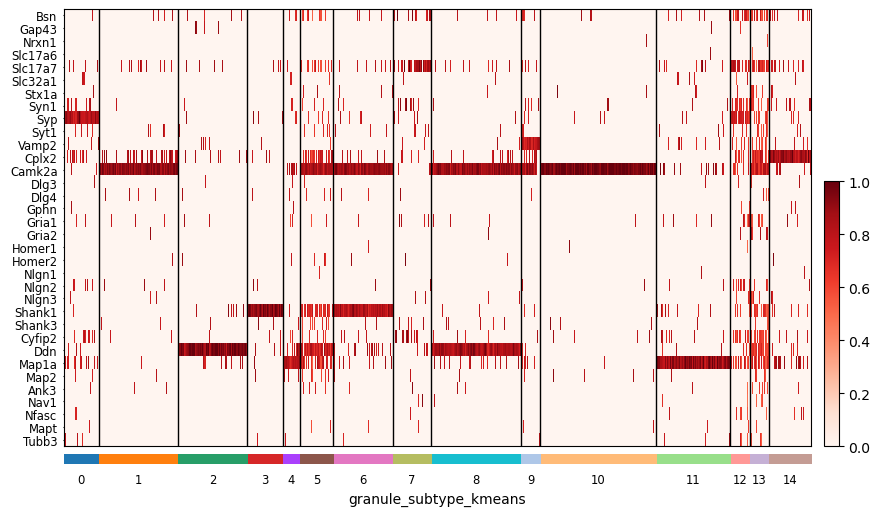

In [14]:
# Heatmap for manual annotation (always save to corresponding directory)
groupby = "granule_subtype_kmeans"
var_names = [g for g in ref_genes if g in adata_combined.var_names]
adata_combined.obs[groupby] = pd.Categorical(adata_combined.obs[groupby], categories=[str(i) for i in range(N_CLUSTERS)], ordered=True)
ax = sc.pl.heatmap(adata_combined, var_names=var_names, groupby=groupby, cmap="Reds", standard_scale="var", dendrogram=False, swap_axes=True, show=False, figsize=(10, 6))
heatmap_out_dir = MAIN_RESULT_DIR if is_main_result else os.path.join(BENCHMARK_ROOT, benchmark_name, COMPARISON_DIR)
os.makedirs(heatmap_out_dir, exist_ok=True)
heatmap_fname = "heatmap_subtype.jpeg" if is_main_result else f"heatmap_subtype_{setting_key}.jpeg"
plt.gcf().savefig(os.path.join(heatmap_out_dir, heatmap_fname), dpi=500, bbox_inches="tight")
plt.show()

In [15]:
# [main result] seed = 42
MANUAL_SUBTYPE_MAPPING = {
    "pre-syn": ["0", "7", "14"],
    "post-syn": ["1", "3", "6", "10"],
    "dendrites": ["2", "11"],
    "axons": [],
    "pre & post": ["9"],
    "pre & den": [],
    "post & den": ["4", "8"],
    "pre & post & den": ["5", "12", "13"],
    "others": [],
}

# MANUAL_SUBTYPE_MAPPING = {
#     "pre-syn": [],
#     "post-syn": [],
#     "dendrites": [],
#     "axons": [],
#     "pre & post": [],
#     "pre & den": [],
#     "post & den": [],
#     "pre & post & den": [],
#     "others": [],
# }

In [16]:
# Apply manual mapping (after you fill MANUAL_SUBTYPE_MAPPING from the heatmap)
cluster_col = "granule_subtype_kmeans"
apply_manual_annotation(adata_combined, MANUAL_SUBTYPE_MAPPING, cluster_column=cluster_col)
adata_combined.obs["granule_subtype_manual_simple"] = pd.Categorical(adata_combined.obs["granule_subtype_manual_simple"], categories=["pre-syn", "post-syn", "dendrites", "axons", "mixed", "others"], ordered=True)
adata_combined.obs["granule_subtype_manual_simple"] = adata_combined.obs["granule_subtype_manual_simple"].cat.remove_unused_categories()

manual_dist = compute_manual_dist(adata_combined, subtype_column="granule_subtype_manual_simple")
print(manual_dist)

{'pre-syn': 0.15519290910673186, 'post-syn': 0.3885835803678392, 'dendrites': 0.19101862155671548, 'axons': 0.0, 'mixed': 0.26520488896871347, 'others': 0.0}


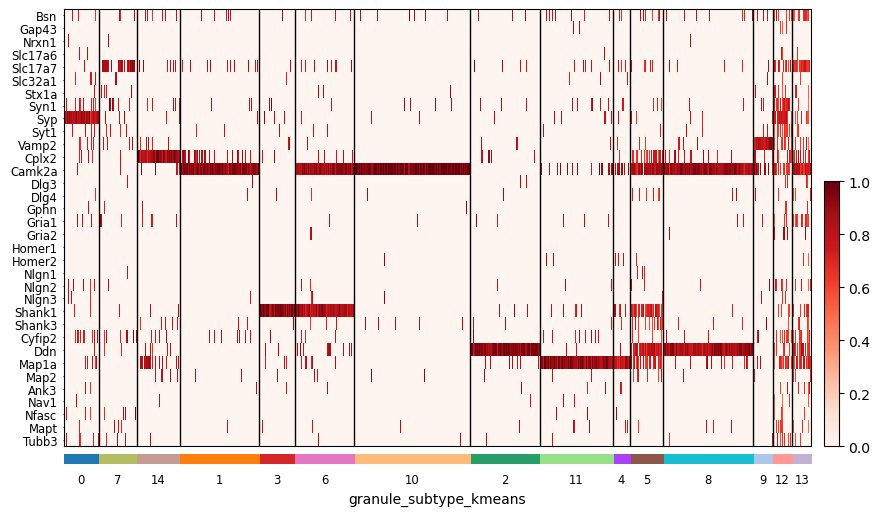

In [17]:
# Main result only: ordered heatmap (x-axis by subtype: pre-syn, post-syn, dendrites, mixed, others; cluster colors match cluster id)
if is_main_result:
    orig_colors = list(adata_combined.uns.get(groupby + "_colors", []))
    cluster_to_simple = {}
    for subtype, clusters in MANUAL_SUBTYPE_MAPPING.items():
        simple = "mixed" if (pd.notna(subtype) and " & " in str(subtype)) else str(subtype)
        for c in clusters:
            cluster_to_simple[str(c)] = simple
    subtype_order = ["pre-syn", "post-syn", "dendrites", "axons", "mixed", "others"]
    ordered_cluster_ids = []
    for simple in subtype_order:
        clusters_here = sorted([c for c, s in cluster_to_simple.items() if s == simple], key=lambda x: int(x))
        ordered_cluster_ids.extend(clusters_here)
    if len(ordered_cluster_ids) == 0:
        ordered_cluster_ids = [str(i) for i in range(N_CLUSTERS)]
    if len(orig_colors) >= N_CLUSTERS:
        adata_combined.uns[groupby + "_colors"] = [orig_colors[int(c)] for c in ordered_cluster_ids]
    adata_combined.obs[groupby] = pd.Categorical(adata_combined.obs[groupby].astype(str), categories=ordered_cluster_ids, ordered=True)
    ax = sc.pl.heatmap(adata_combined, var_names=var_names, groupby=groupby, cmap="Reds", standard_scale="var", dendrogram=False, swap_axes=True, show=False, figsize=(10, 6))
    plt.gcf().savefig(os.path.join(MAIN_RESULT_DIR, "heatmap_subtype_ordered.jpeg"), dpi=500, bbox_inches="tight")
    plt.show()
    adata_combined.obs[groupby] = pd.Categorical(adata_combined.obs[groupby], categories=[str(i) for i in range(N_CLUSTERS)], ordered=True)
    if len(orig_colors) >= N_CLUSTERS:
        adata_combined.uns[groupby + "_colors"] = orig_colors[:N_CLUSTERS]

In [18]:
# Main result only: plot tSNE (already in data) colored by sample and granule subtype
if is_main_result:
    
    # Plot tSNE colored by sample
    sc.set_figure_params(figsize = (8, 8))
    ax = sc.pl.tsne(adata_combined, color = "sample_simple", palette={"WT": "#a0ccec", "AD": "#f48488"}, size = 1, show = False)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("")
    for spine in ax.spines.values():
        spine.set_visible(False)
    plt.gcf().savefig(os.path.join(MAIN_RESULT_DIR, "granules_by_batch_tsne.jpeg"), dpi=500, bbox_inches="tight")
    plt.close()
    
    # Plot tSNE colored by granule subtype
    for col in ["granule_subtype_kmeans", "granule_subtype_manual", "granule_subtype_manual_simple"]:
        if adata_combined.obs[col].nunique() <= 10:
            adata_combined = assign_palette_to_adata(adata_combined, obs_key = col, cmap_name = "Set2")
        sc.set_figure_params(figsize = (8, 8))
        ax = sc.pl.embedding(adata_combined, basis="tsne", color=col, size=1, show=False)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_title("")
        for spine in ax.spines.values():
            spine.set_visible(False)
        plt.gcf().savefig(os.path.join(MAIN_RESULT_DIR, f"{col}_tsne.jpeg"), dpi=500, bbox_inches="tight")
        plt.close()

In [19]:
# Automatic subtyping: tuning step (run after you have manual proportions)
results_df, best_enrich, best_zscore = run_automatic_tuning_grid(adata_combined, marker_genes, manual_dist, cluster_column=None)
print(results_df.sort_values('least_square_error').head(10))

# # Then run with best hyperparameters:
# run_automatic_subtyping(adata_combined, marker_genes, enrichment_threshold=0.3, min_zscore_threshold=0.0)

    enrich_thr  zscore_thr   pre-syn  post-syn  dendrites     axons     mixed  \
0         0.20        -1.0  0.160404  0.109393   0.260685  0.028536  0.211700   
1         0.20        -0.5  0.160404  0.109393   0.260685  0.028536  0.211700   
2         0.20         0.0  0.160404  0.109393   0.260685  0.028536  0.211700   
9         0.25         0.0  0.175078  0.120956   0.266660  0.032743  0.175281   
8         0.25        -0.5  0.175078  0.120956   0.266660  0.032743  0.175281   
7         0.25        -1.0  0.175078  0.120956   0.266660  0.032743  0.175281   
16        0.30         0.0  0.191455  0.133597   0.274370  0.038741  0.132255   
14        0.30        -1.0  0.191455  0.133597   0.274370  0.038741  0.132255   
15        0.30        -0.5  0.191455  0.133597   0.274370  0.038741  0.132255   
23        0.35         0.0  0.206897  0.145518   0.282726  0.044275  0.088766   

      others  least_square_error  
0   0.229282            0.139075  
1   0.229282            0.139075  
2  

In [20]:
results_df

,enrich_thr,zscore_thr,pre-syn,post-syn,dendrites,axons,mixed,others,least_square_error
0,0.2,-1.0,0.160404,0.109393,0.260685,0.028536,0.211700,0.229282,0.139075
1,0.2,-0.5,0.160404,0.109393,0.260685,0.028536,0.211700,0.229282,0.139075
2,0.2,0.0,0.160404,0.109393,0.260685,0.028536,0.211700,0.229282,0.139075
3,0.2,0.5,0.144582,0.116276,0.126956,0.028536,0.187401,0.396249,0.242249
4,0.2,1.0,0.121550,0.114964,0.069046,0.028536,0.169405,0.496499,0.347380
...,...,...,...,...,...,...,...,...,...
58,0.6,0.0,0.201714,0.138543,0.282854,0.039806,0.000000,0.337082,0.258661
59,0.6,0.5,0.175561,0.138493,0.145044,0.039806,0.000000,0.501095,0.388088
60,0.6,1.0,0.148784,0.131592,0.081388,0.039806,0.000000,0.598430,0.508141
61,0.6,1.5,0.128298,0.085886,0.080423,0.039806,0.000000,0.665587,0.619505


In [ ]:
# Density: use granule_subtype_manual_simple (mixed types → 'mixed'). Overlay granules to their sample's spots only.
spots_wt = sc.read_h5ad(os.path.join(DATA_PATH_WT, "processed_data/spots.h5ad"))
spots_ad = sc.read_h5ad(os.path.join(DATA_PATH_AD, "processed_data/spots.h5ad"))
if "brain_area" in spots_wt.obs.columns and "brain_area" in spots_ad.obs.columns:
    density_df_wt = compute_subtype_density_per_region(adata_combined.obs[adata_combined.obs["sample"] == "MERSCOPE_WT_1"], spots_wt, subtype_col="granule_subtype_manual_simple")
    density_df_ad = compute_subtype_density_per_region(adata_combined.obs[adata_combined.obs["sample"] == "MERSCOPE_AD_1"], spots_ad, subtype_col="granule_subtype_manual_simple")
    density_df = pd.concat([density_df_wt, density_df_ad], ignore_index=True)
    density_df["setting"] = setting_key
print(density_df.head())

In [ ]:
# WT synaptic granule density vs ground truth (HPF-SR excluded). Synaptic granules defined by granule_subtype_manual only (SYNAPTIC_SUBTYPES).
if "brain_area" not in spots_wt.obs.columns:
    print(f"Setting {setting_key}: skip correlation (no brain_area in spots)")
else:
    subtype_col_synaptic = "granule_subtype_manual"  # use finer annotation only for defining synaptic
    obs_wt = adata_combined.obs[adata_combined.obs["sample"] == "MERSCOPE_WT_1"].copy()
    obs_wt_synaptic = obs_wt[obs_wt[subtype_col_synaptic].isin(SYNAPTIC_SUBTYPES)].copy()
    obs_wt_synaptic["_synaptic_agg"] = "synaptic"
    density_synaptic_df = compute_subtype_density_per_region(obs_wt_synaptic, spots_wt, subtype_col="_synaptic_agg")
    df_wt_synaptic = density_synaptic_df[(density_synaptic_df["sample"] == "MERSCOPE_WT_1") & (density_synaptic_df["subtype"] == "synaptic")]
    wt_density_list = df_wt_synaptic.set_index("brain_area").reindex(AREA_LIST)["density"].values
    wt_density_list = np.nan_to_num(wt_density_list, nan=0.0)
    wt_list_no_hpfsr_ft = np.delete(wt_density_list, [4, 8])
    gt_no_hpfsr_ft = np.delete(np.array(GROUND_TRUTH_DENSITIES), [4, 8])
    weights = [np.sum(spots_wt.obs["brain_area"] == i) for i in AREA_LIST]
    weights_no_hpfsr_ft = weights.copy()
    weights_no_hpfsr_ft.pop(8)
    weights_no_hpfsr_ft.pop(4)
    scaled_wt = scale(wt_list_no_hpfsr_ft)
    scaled_gt = scale(gt_no_hpfsr_ft)
    # r_pearson = weighted_corr(scaled_wt, scaled_gt, weights_no_hpfsr_ft)
    # r_spearman = weighted_spearmanr(scaled_wt, scaled_gt, weights_no_hpfsr_ft)
    r_pearson = weighted_corr(wt_list_no_hpfsr_ft, gt_no_hpfsr_ft, weights_no_hpfsr_ft)
    r_spearman = weighted_spearmanr(wt_list_no_hpfsr_ft, gt_no_hpfsr_ft, weights_no_hpfsr_ft)
    print(f"Setting {setting_key}: weighted Pearson = {r_pearson:.4f}, weighted Spearman = {r_spearman:.4f}")

In [ ]:
# Export labels and density (main result → MAIN_RESULT_DIR, else benchmark_xxx/WT_AD_comparison/)
if is_main_result:
    export_setting_results(benchmark_name, setting_key, BENCHMARK_ROOT, COMPARISON_DIR, adata_combined, subtype_col="granule_subtype_manual_simple", density_df=density_df, out_dir=MAIN_RESULT_DIR)
else:
    export_setting_results(benchmark_name, setting_key, BENCHMARK_ROOT, COMPARISON_DIR, adata_combined, subtype_col="granule_subtype_manual_simple", density_df=density_df)

In [ ]:
# Main result only: run k-means for extra k (20, 25, 30) and save subtype labels parquet only (no tSNE, heatmap, or density)
if is_main_result:
    for k in MAIN_RESULT_EXTRA_K:
        run_manual_subtyping(adata_combined, n_clusters=k, seed=SEED, batch_size=KMEANS_BATCH_SIZE, n_init=KMEANS_N_INIT, obs_key=f"granule_subtype_kmeans_k{k}")
        export_labels_only(adata_combined, MAIN_RESULT_DIR, f"granule_adata_tsne_k{k}", label_col=f"granule_subtype_kmeans_k{k}")

## 6. Run automatic subtyping on benchmarking datasets

In [ ]:
for benchmark_name, filename in BENCHMARK_SETTINGS:
    
    # skip main result
    is_main_result = (benchmark_name == "main_result")
    if is_main_result:
        continue
    
    setting_key = os.path.splitext(filename)[0]
    print(f"Processing: {benchmark_name} / {filename} (setting_key={setting_key})")
    
    # load data
    adata_combined = concatenate_wt_ad_for_setting(benchmark_name, filename, genes_wt, genes_ad, transcripts_wt, transcripts_ad, nc_wt, nc_ad, ref_genes_common)
    sc.pp.normalize_total(adata_combined, target_sum=1e4)
    sc.pp.log1p(adata_combined)
    print(adata_combined.shape)
    print(adata_combined.obs["sample"].value_counts())
    
    # run automatic subtyping
    run_automatic_subtyping(adata_combined, marker_genes, enrichment_threshold=0.3, min_zscore_threshold=0.0, cluster_column=None)
    print(adata_combined.obs["granule_subtype_automated_simple"].value_counts(normalize=True))